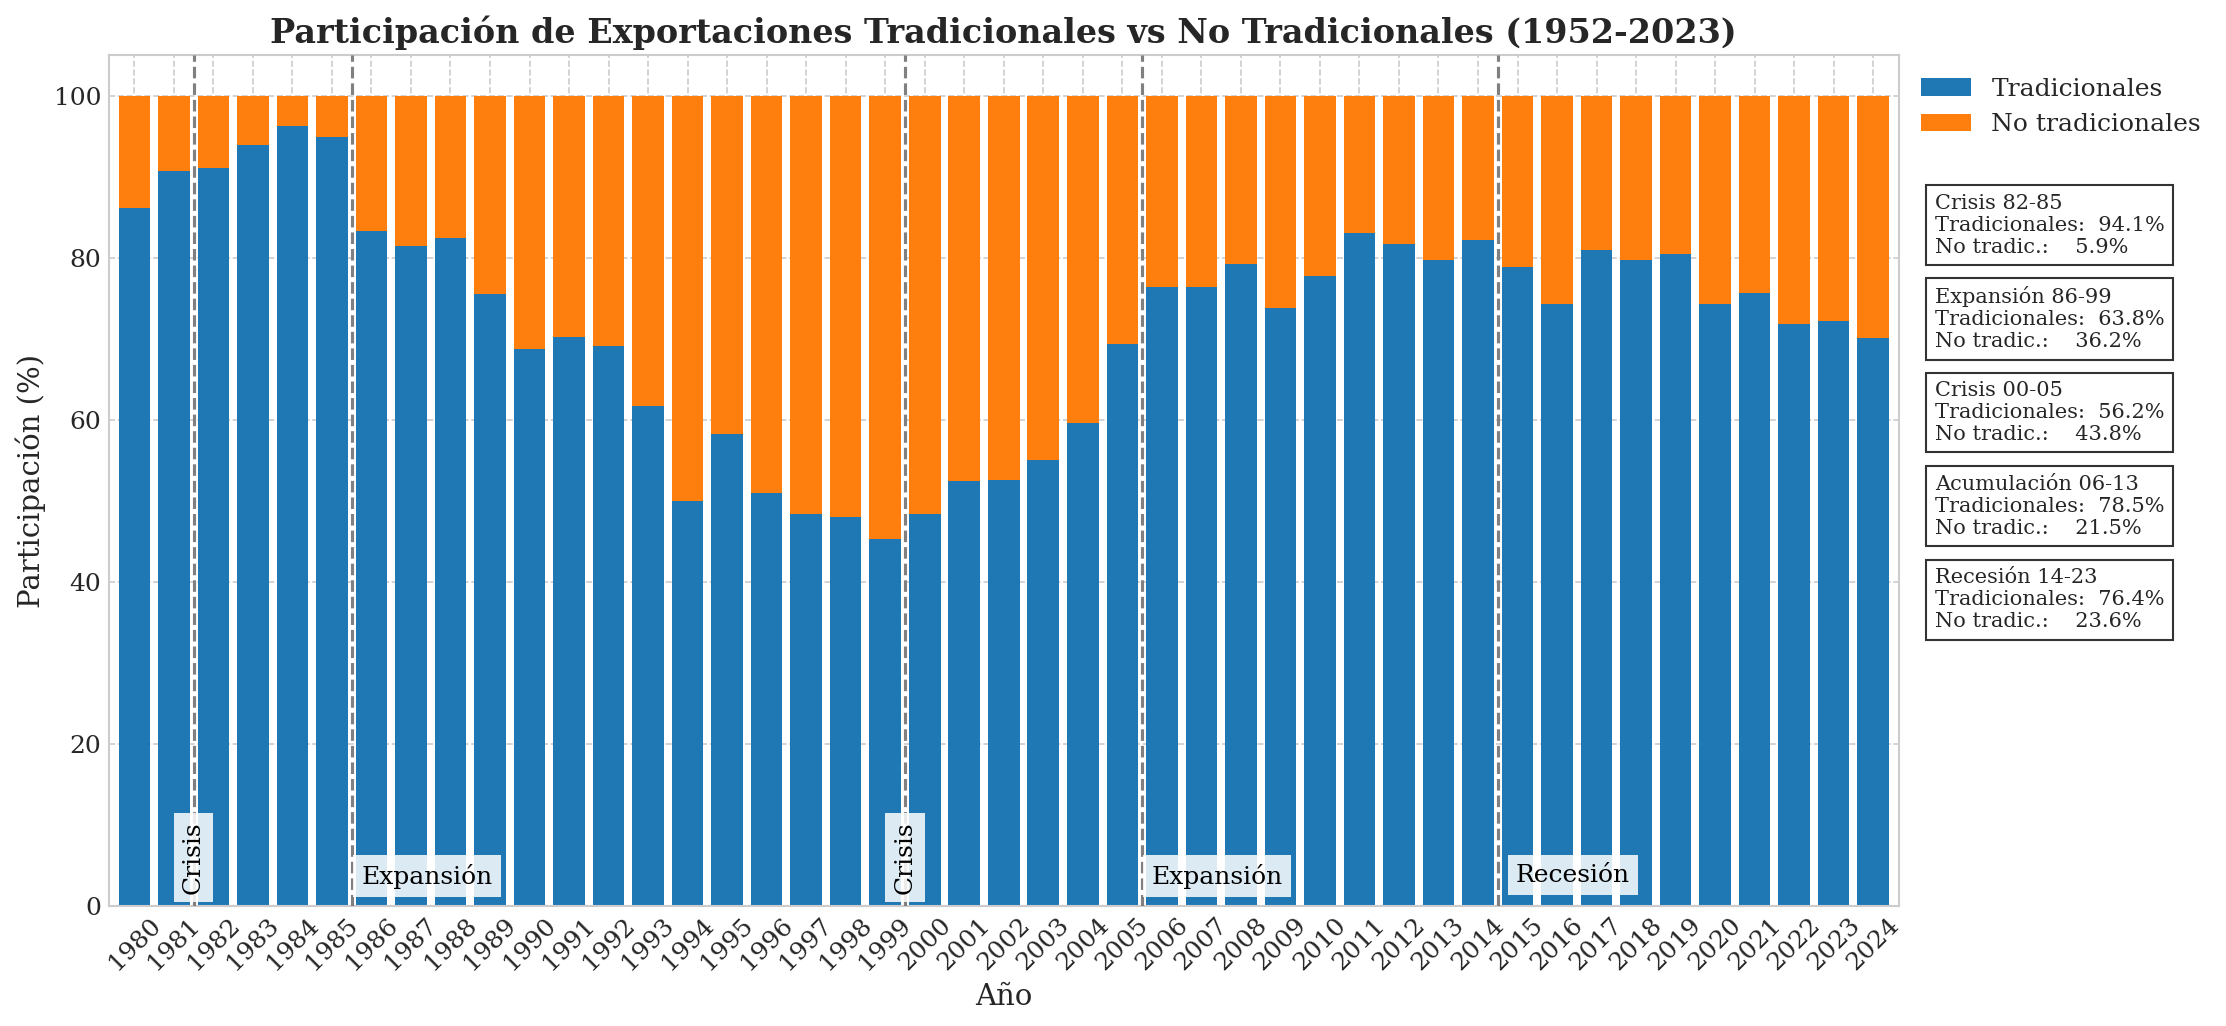

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Parámetros y rutas ─────────────────────────────────────────────────────
OUTPUT_DIR = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── 2. Slices de ciclo (periodos macro) ───────────────────────────────────────
CYCLES = {
    "Crisis 82-85":       slice(1982, 1985),
    "Expansión 86-99":    slice(1986, 1999),
    "Crisis 00-05":       slice(2000, 2005),
    "Acumulación 06-13":  slice(2006, 2013),
    "Recesión 14-23":     slice(2014, 2024),   # ajusta a 2024+ si añades más datos
}

# ── 3. Hitos visuales (líneas verticales) ─────────────────────────────────────
hitos_v = {
    1981: "Crisis", 1985: "Expansión", 1999: "Crisis",
    2005: "Expansión", 2014: "Recesión"
}
hitos_offset = {
    1981: (0, 0.10),
    1985: (1.9, 0.05),
    1999: (0, 0.10),
    2005: (1.9, 0.05),
    2014: (1.9, 0.05)
}
# ── 4. Cargar datos completos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql_query(
        "SELECT * FROM exportaciones_tradicionales_no_tradicionales", conn
    ).set_index("año")

# NO recortar la serie -> se grafica todo el rango disponible
df["total"] = df["tradicionales"] + df["no_tradicionales"]
pct = df[["tradicionales", "no_tradicionales"]].div(df["total"], axis=0) * 100

# ── 5. Estadísticas promedio por ciclo ────────────────────────────────────────
cycle_stats = {
    name: pct.loc[slice_].mean() for name, slice_ in CYCLES.items()
}

# ── 6. Gráfico stacked bar ────────────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16, "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150, "savefig.bbox": "tight"
})

fig, ax = plt.subplots(figsize=(15, 7))
pct.plot(kind="bar", stacked=True, ax=ax, width=0.8)

ax.set_ylabel("Participación (%)")
ax.set_xlabel("Año")
ax.set_title("Participación de Exportaciones Tradicionales vs No Tradicionales (1952-2023)",
             fontweight="bold")
ax.legend(["Tradicionales", "No tradicionales"], loc="upper left",
          bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

# ── 7. Insertar hitos visuales ────────────────────────────────────────────────
fig.subplots_adjust(right=0.74)  # deja margen a la derecha para estadísticas
for yr, lbl in hitos_v.items():
    if yr in pct.index:
        idx = pct.index.get_loc(yr)
        y_max=ax.get_ylim()[1]
        ax.axvline(
            x=idx + 0.5, color="gray", ls="--", lw=1.5, zorder=5
        )
        dx,dy=hitos_offset.get(yr,(0,0.5))
        ax.text(
            idx + 0.5+dx,dy, lbl, rotation=0 if lbl=='Expansión' or lbl=='Recesión' else 90, ha="center", va="top",
            fontsize=12, color="black",
            transform=ax.get_xaxis_transform(), clip_on=False,
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"),
            zorder=6
        )

# ── 8. Cuadros con promedios por ciclo ────────────────────────────────────────
y0 = 0.80            # posición inicial en el eje Y (transAxes)
dy = 0.11            # espacio vertical entre cuadros
for i, (name, stats) in enumerate(cycle_stats.items()):
    text = (
        f"{name}\n"
        f"Tradicionales:  {stats['tradicionales']:.1f}%\n"
        f"No tradic.:    {stats['no_tradicionales']:.1f}%"
    )
    ax.text(1.02, y0 - i*dy, text,
            transform=ax.transAxes, fontsize=10, va="center", ha="left",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

# ── 9. Guardar y mostrar ──────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "participacion_exportaciones.png"),
            dpi=300)
plt.show()

# ── 10. Verificación ──────────────────────────────────────────────────────────
assert abs(pct.sum(axis=1) - 100).max() < 1e-6, "Las participaciones no suman 100%"

Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


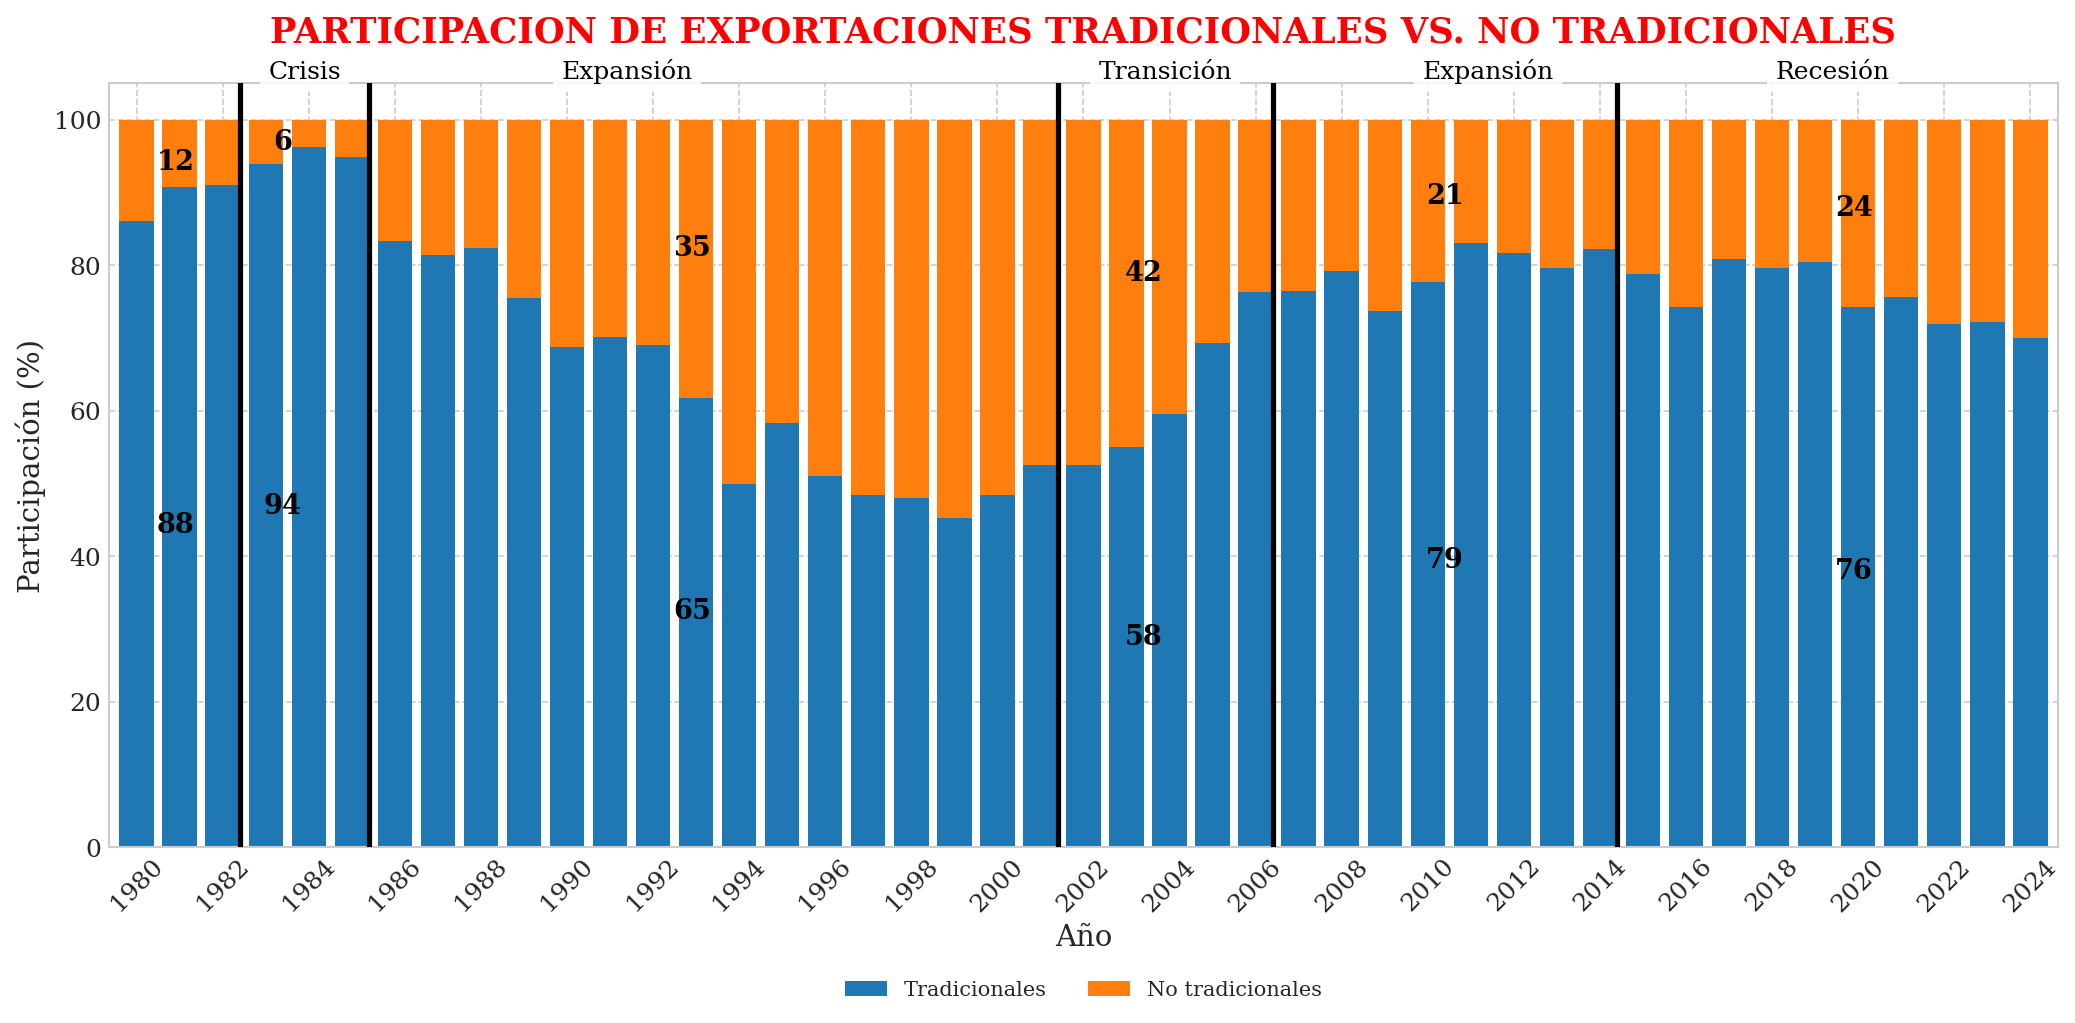

Imagen guardada en: ../../../../assets/tesis/serie_completa/exportaciones/participacion_exportaciones.png


In [4]:
"""
GRÁFICA – Participación de Exportaciones Tradicionales vs. No Tradicionales
Versión refactorizada con utilidades estándar de barras apiladas.
"""

# ──────────────────────── 1. Imports y estilo ──────────────────────────────
import os, sqlite3
import pandas as pd

from func_auxiliares.config import *            # set_style, paletas, etc.
from func_auxiliares.graficos_utils import *    # adjust_cycles, plot_stacked_bar,
                                                # add_hitos_barras, add_cycle_means_barras

OUTPUT_DIR = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()

# ──────────────────────── 2. Carga de datos ────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (
        pd.read_sql_query("SELECT * FROM exportaciones_tradicionales_no_tradicionales", conn)
          .set_index("año")
    )

# ──────────────────────── 3. Componentes y % ───────────────────────────────
componentes = [
    ("tradicionales",     "Tradicionales"),
    ("no_tradicionales",  "No tradicionales"),
]
cols = [c for c, _ in componentes]

df["total"] = df[cols].sum(axis=1)
pct = df[cols].div(df["total"], axis=0) * 100

# ──────────────────────── 4. Ciclos y promedios ────────────────────────────

cycles_adj = adjust_cycles(df, CYCLES)

cycle_stats = {
    name: pct.loc[slice_, cols].mean().to_dict()
    for name, slice_ in cycles_adj.items()
}

# ──────────────────────── 5. Hitos y offsets ───────────────────────────────
hitos_offset = {
    1952: (0, 1),
    1956: (0, 1),
    1970: (0, 1),
    1982: (0, 1),
    1985: (0, 1),
    2001: (0, 1),
    2006: (0, 1),
    2014: (0, 1)
}
hitos_text_x = {
    1952: 1.9,
    1956: 6,
    1970: 5,
    1982: 1.5,
    1985: 6,
    2001: 2.5,
    2006: 5,
    2014: 5
}

# Sin desplazamientos especiales para las cajas (dos series)
MEAN_OFFSETS_BY_NAME = {}
SKIP_MEANS_BY_NAME   = {}

# ──────────────────────── 6. Gráfico ────────────────────────────────────────
fig, ax = plot_stacked_bar(
    pct,
    series=componentes,
    title="PARTICIPACION DE EXPORTACIONES TRADICIONALES VS. NO TRADICIONALES",
    legend_ncol=2
)

add_hitos_barras(
    ax, df.index, hitos_v, hitos_offset, hitos_text_x
)

add_cycle_means_barras(
    ax,
    index=list(df.index),
    cycle_slices=cycles_adj,
    cycle_stats=cycle_stats,
    cols=cols,
    offsets=MEAN_OFFSETS_BY_NAME,
    skip=SKIP_MEANS_BY_NAME
)

# ──────────────────────── 7. Guardar / mostrar ─────────────────────────────
plt.tight_layout()
out_path = os.path.join(OUTPUT_DIR, "participacion_exportaciones.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Imagen guardada en: {out_path}")

# ──────────────────────── 8. Verificación ──────────────────────────────────
assert abs(pct.sum(axis=1) - 100).max() < 1e-6, "Las participaciones no suman 100%"
